In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import yaml

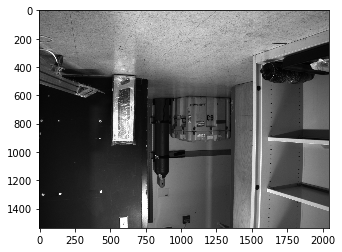

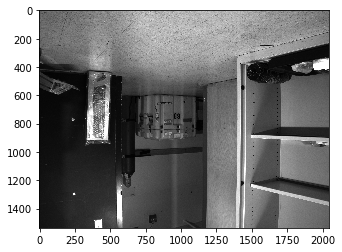

In [51]:

imgL = cv2.imread('images/left_raw.png')
imgR = cv2.imread('images/right_raw.png')

imgLmono = cv2.cvtColor(imgL, cv2.COLOR_RGB2GRAY)
imgRmono = imgR[:,:,1]

plt.imshow(imgLmono, cmap="gray")
plt.show()

plt.imshow(imgRmono, cmap="gray")
plt.show()

In [52]:
import pprint as pp

def mat_from_dict( d ):
    return np.reshape( d['data'], (d['rows'], d['cols'] ) )

def cam_from_yaml( y ):
    return { 'size': (y['image_width'], y['image_height']),
             'K': mat_from_dict( y['camera_matrix'] ),
             'dist': mat_from_dict( y['distortion_coefficients']),
             'projection': mat_from_dict( y['projection_matrix']),
             'rectification': mat_from_dict( y['rectification_matrix'])}

with open("camera_info/18457940.yaml") as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    leftCam = cam_from_yaml( y )
    
with open("camera_info/18296567.yaml") as f:
    y = yaml.load(f, Loader=yaml.SafeLoader)
    rightCam = cam_from_yaml(y)
    
pp.pprint(leftCam)
    
    

{'K': array([[1.83874190e+03, 0.00000000e+00, 1.03742237e+03],
       [0.00000000e+00, 1.83567452e+03, 7.39303998e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[-0.176484,  0.104623, -0.00046 ,  0.000468,  0.      ]]),
 'projection': array([[-1.29929126e+03,  0.00000000e+00,  1.07792867e+03,
         1.97020303e+02],
       [ 0.00000000e+00, -1.29929126e+03,  8.04322227e+02,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]]),
 'rectification': array([[-9.93993e-01,  4.35000e-03, -1.09361e-01],
       [-4.39300e-03, -9.99990e-01,  1.51000e-04],
       [-1.09359e-01,  6.31000e-04,  9.94002e-01]]),
 'size': (2048, 1536)}


## Just Undistort

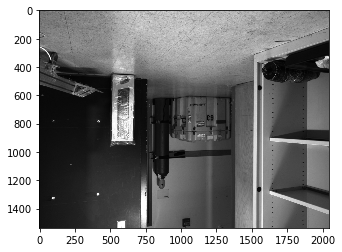

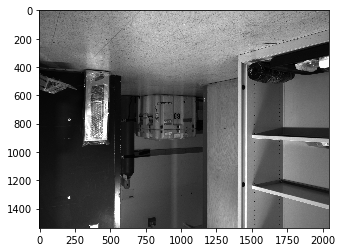

In [53]:
imgLundistort = cv2.undistort( imgLmono,  leftCam['K'],  leftCam['dist'])
imgRundistort = cv2.undistort( imgRmono, rightCam['K'], rightCam['dist'])

plt.imshow(imgLundistort, cmap="gray")
plt.show()
plt.imshow(imgRundistort, cmap="gray")
plt.show()

## Rectify

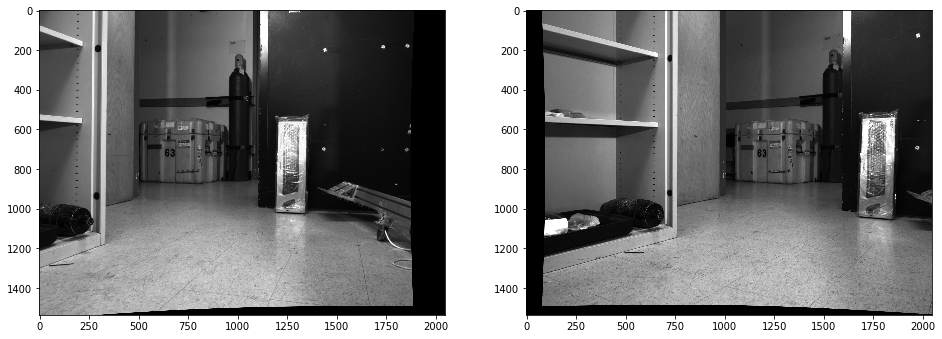

In [75]:
def remap( img, cam ):
    map1,map2 = cv2.initUndistortRectifyMap( cam['K'], cam['dist'], cam['rectification'], cam['K'], cam['size'], cv2.CV_32FC1)
    return cv2.remap(img, map1, map2, cv2.INTER_LINEAR);

imgLrect = remap( imgLmono, leftCam )
imgRrect = remap( imgRmono, rightCam )


fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(imgLrect, cmap="gray")
axs[1].imshow(imgRrect, cmap="gray")
plt.show()

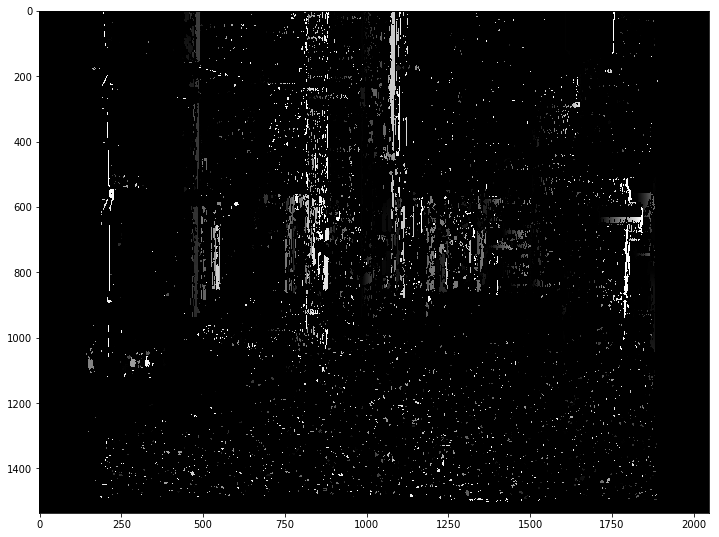

In [77]:
def do_stereo( stereo ):
    disparity = stereo.compute(imgLrect,imgRrect)

    plt.figure(figsize=(12,12))
    plt.imshow(disparity,'gray', )
    plt.show()

   
bm = cv2.StereoBM_create(numDisparities=128, blockSize=15)
bm.setTextureThreshold(4)
bm.setMinDisparity(0)

do_stereo(bm)


## SGBN

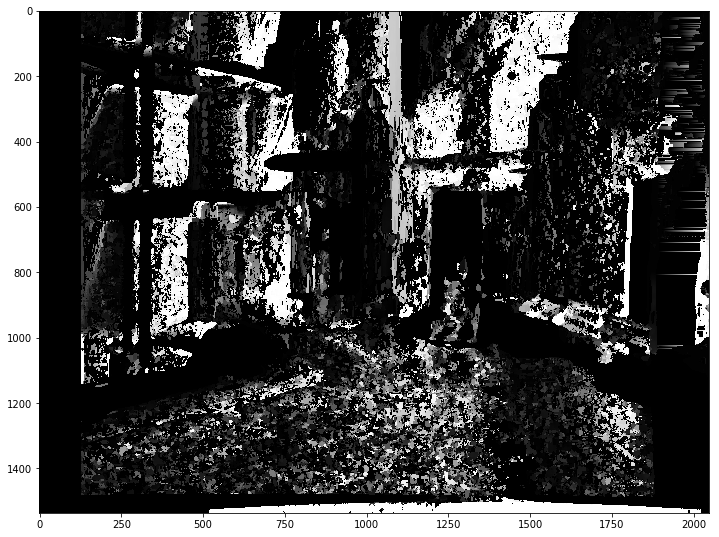

In [79]:

max_disparity = 128;
sgbm = cv2.StereoSGBM_create(0, max_disparity, 21);

do_stereo(sgbm)
